In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt

In [2]:
symbol = "AAPL"
history_points = 50

In [6]:
data = pd.read_csv('GOOGL.csv')
data = data.drop('date', axis=1)
## reverse index because .csv top column is most recent price
data = data[::-1]
data = data.reset_index()
data = data.drop('index', axis=1)
print(data)

       1. open  2. high    3. low  4. close   5. volume
0      100.010   104.06    95.960   100.335  44659000.0
1      101.010   109.08   100.500   108.310  22834300.0
2      110.760   113.48   109.050   109.400  18256100.0
3      111.240   111.60   103.570   104.870  15247300.0
4      104.760   108.00   103.880   106.000   9188600.0
...        ...      ...       ...       ...         ...
4294  2876.810  2886.21  2863.550  2870.820    765855.0
4295  2884.250  2894.37  2814.755  2817.520   1841967.0
4296  2838.990  2859.00  2825.000  2846.650   1104692.0
4297  2859.905  2867.26  2835.000  2850.890    983693.0
4298  2855.430  2889.01  2826.950  2888.590   1187702.0

[4299 rows x 5 columns]


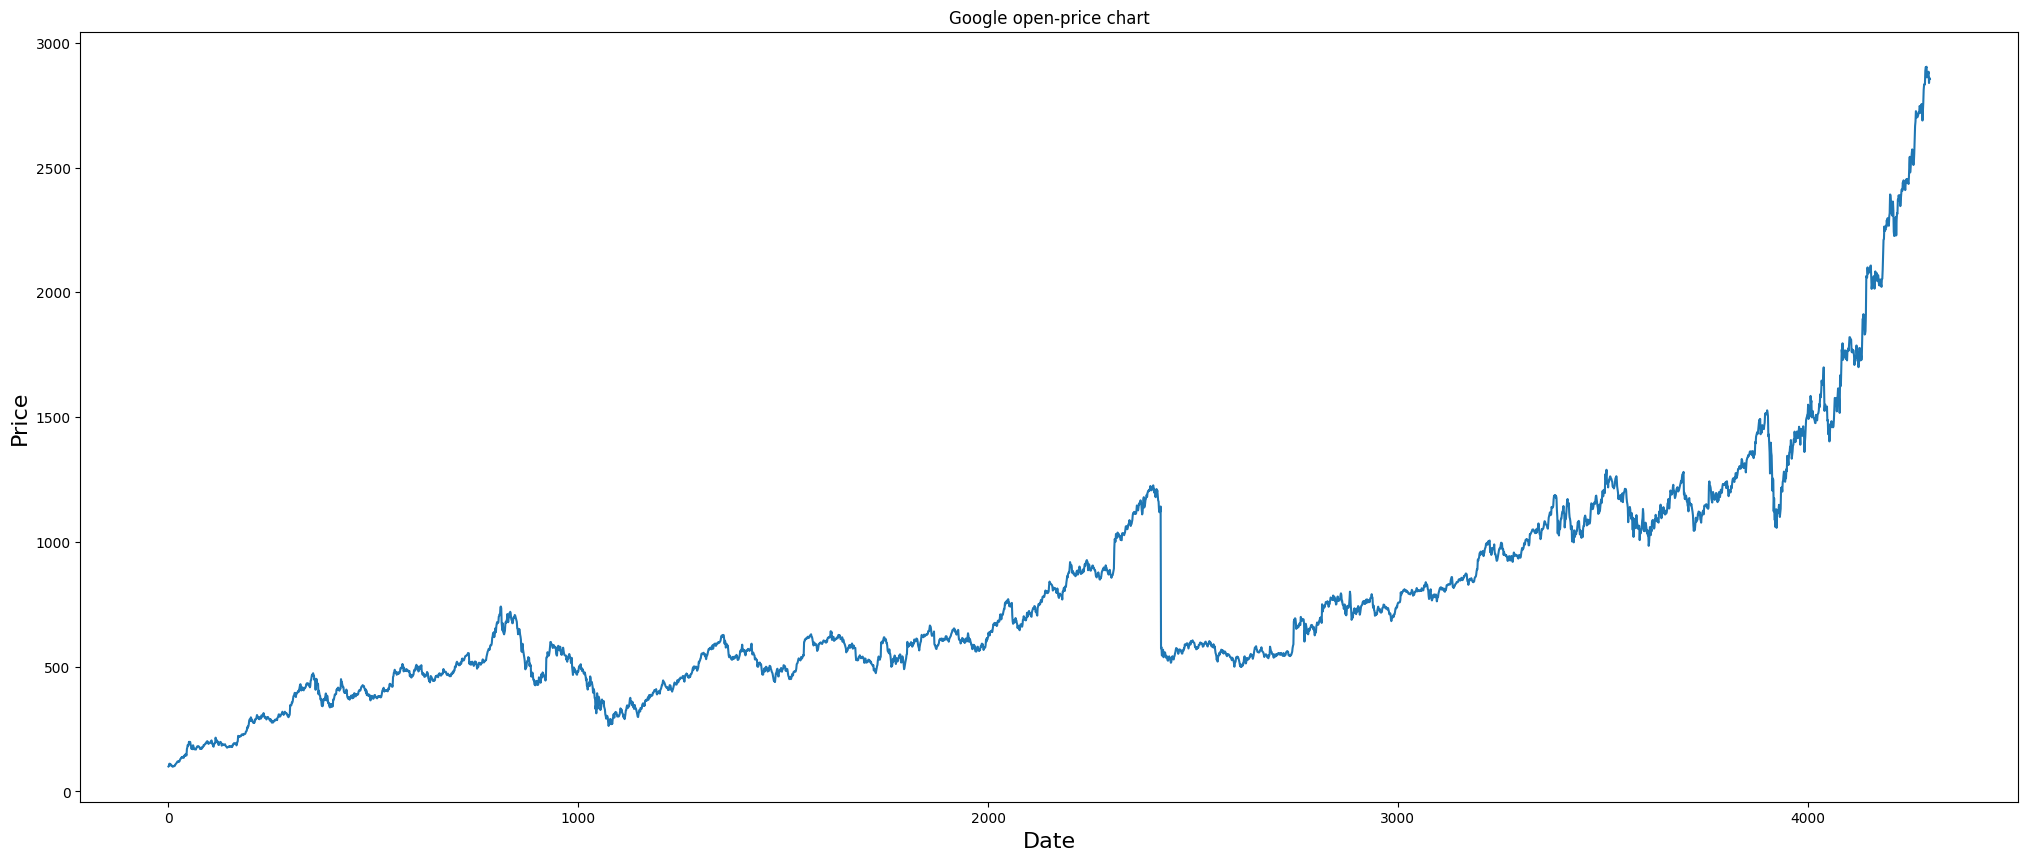

In [7]:
# plot openning value stock chart
plt.subplots(figsize = (25,10))
plt.ylabel('Price', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.title('Google open-price chart')
plt.plot(data.loc[:,'1. open'] ) # plot openning value chart
plt.show()

In [8]:
# ohlc-values normaliser
data_normaliser = preprocessing.MinMaxScaler()
data_normalised = data_normaliser.fit_transform(data)
# using the last {history_points} open high low close volume data points, predict the next open value
ohlcv_histories_normalised = np.array([data_normalised[i: i + history_points].copy() for i in range(len(data_normalised) - history_points)])
print(ohlcv_histories_normalised.shape)

(4249, 50, 5)


In [9]:
print(data.shape)

(4299, 5)


In [10]:
# next-day-open-values normalised
next_day_open_values_normalised = np.array([data_normalised[:,0][i + history_points].copy() for i in range(len(data_normalised) - history_points)])
next_day_open_values_normalised = np.expand_dims(next_day_open_values_normalised, -1)

next_day_open_values = np.array([data.loc[:,"1. open"][i + history_points].copy() for i in range(len(data) - history_points)])
next_day_open_values = np.expand_dims(next_day_open_values, -1)

y_scaler = preprocessing.MinMaxScaler()
y_scaler.fit(next_day_open_values)

print(ohlcv_histories_normalised.shape[0] == next_day_open_values_normalised.shape[0])

True


In [11]:
test_split = 0.9 # 90% stock-history for training, most-recent 10% stock-history for testing
n = int(ohlcv_histories_normalised.shape[0] * test_split)
print(n)

3824


In [12]:
ohlcv_train = ohlcv_histories_normalised[:n]
y_train = next_day_open_values_normalised[:n]

ohlcv_test = ohlcv_histories_normalised[n:]
y_test = next_day_open_values_normalised[n:]

unscaled_y_test = next_day_open_values[n:]

In [13]:
print(ohlcv_train.shape)
print(y_train.shape)

print(ohlcv_test.shape)
print(y_test.shape)

print(unscaled_y_test.shape)

(3824, 50, 5)
(3824, 1)
(425, 50, 5)
(425, 1)
(425, 1)


In [14]:
import tensorflow.keras as keras
from tensorflow.keras import models, layers
# Build Model
lstm_input = layers.Input(shape=(history_points, 5))

x = layers.LSTM(50)(lstm_input)
#x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='sigmoid')(x)
output = layers.Dense(1, activation='linear')(x)

model = models.Model(inputs=lstm_input, outputs=output)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 5)]           0         
                                                                 
 lstm (LSTM)                 (None, 50)                11200     
                                                                 
 dense (Dense)               (None, 64)                3264      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 14,529
Trainable params: 14,529
Non-trainable params: 0
_________________________________________________________________


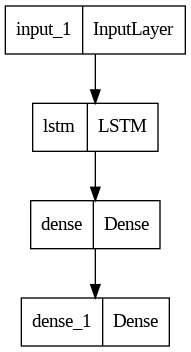

In [15]:
keras.utils.plot_model(model = model , to_file = 'StockLSTM.png')

In [16]:
# Compile Model
model.compile(loss='mse', optimizer='adam')

In [17]:
num_epochs= 50
batch_size = 32

In [18]:
# Train Model
model.fit(ohlcv_train, y_train, batch_size=batch_size, epochs=num_epochs, shuffle=True, validation_split=0.1)

Epoch 1/50
108/108 [==============================] - 7s 35ms/step - loss: 0.0197 - val_loss: 3.6618e-04
Epoch 2/50
108/108 [==============================] - 3s 28ms/step - loss: 4.5626e-04 - val_loss: 9.7063e-04
Epoch 3/50
108/108 [==============================] - 3s 23ms/step - loss: 2.4662e-04 - val_loss: 1.8319e-04
Epoch 4/50
108/108 [==============================] - 2s 23ms/step - loss: 1.5345e-04 - val_loss: 1.3771e-04
Epoch 5/50
108/108 [==============================] - 3s 23ms/step - loss: 1.3546e-04 - val_loss: 1.3036e-04
Epoch 6/50
108/108 [==============================] - 5s 45ms/step - loss: 1.0487e-04 - val_loss: 1.8009e-04
Epoch 7/50
108/108 [==============================] - 3s 27ms/step - loss: 9.4662e-05 - val_loss: 8.2900e-05
Epoch 8/50
108/108 [==============================] - 3s 23ms/step - loss: 8.7656e-05 - val_loss: 1.7838e-04
Epoch 9/50
108/108 [==============================] - 2s 23ms/step - loss: 7.5438e-05 - val_loss: 8.1974e-05
Epoch 10/50
108/108 [==

In [19]:
evaluation = model.evaluate(ohlcv_test, y_test)
print(evaluation)

14/14 [==============================] - 0s 9ms/step - loss: 0.0011
0.0010625023860484362


In [20]:
y_test_predicted = model.predict(ohlcv_test)
print(y_test_predicted.shape)

# model.predict returns normalised values, now we scale them back up using the y_scaler from before
y_test_predicted = y_scaler.inverse_transform(y_test_predicted)

14/14 [==============================] - 1s 8ms/step
(425, 1)


In [21]:
y_predicted = model.predict(ohlcv_histories_normalised)
print(y_predicted.shape)
y_predicted = y_scaler.inverse_transform(y_predicted)

133/133 [==============================] - 2s 12ms/step
(4249, 1)


In [22]:
print(unscaled_y_test.shape == y_test_predicted.shape)
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print(scaled_mse)

True
383.33772617599817


In [23]:
train  = data.loc[history_points: n+history_points,'1. open']
actual = data.loc[n+history_points:,'1. open']
print(len(train))
print(len(actual))

3825
425


In [24]:
valid=pd.DataFrame()
valid['Actual'] = actual
valid['Prediction'] = y_test_predicted

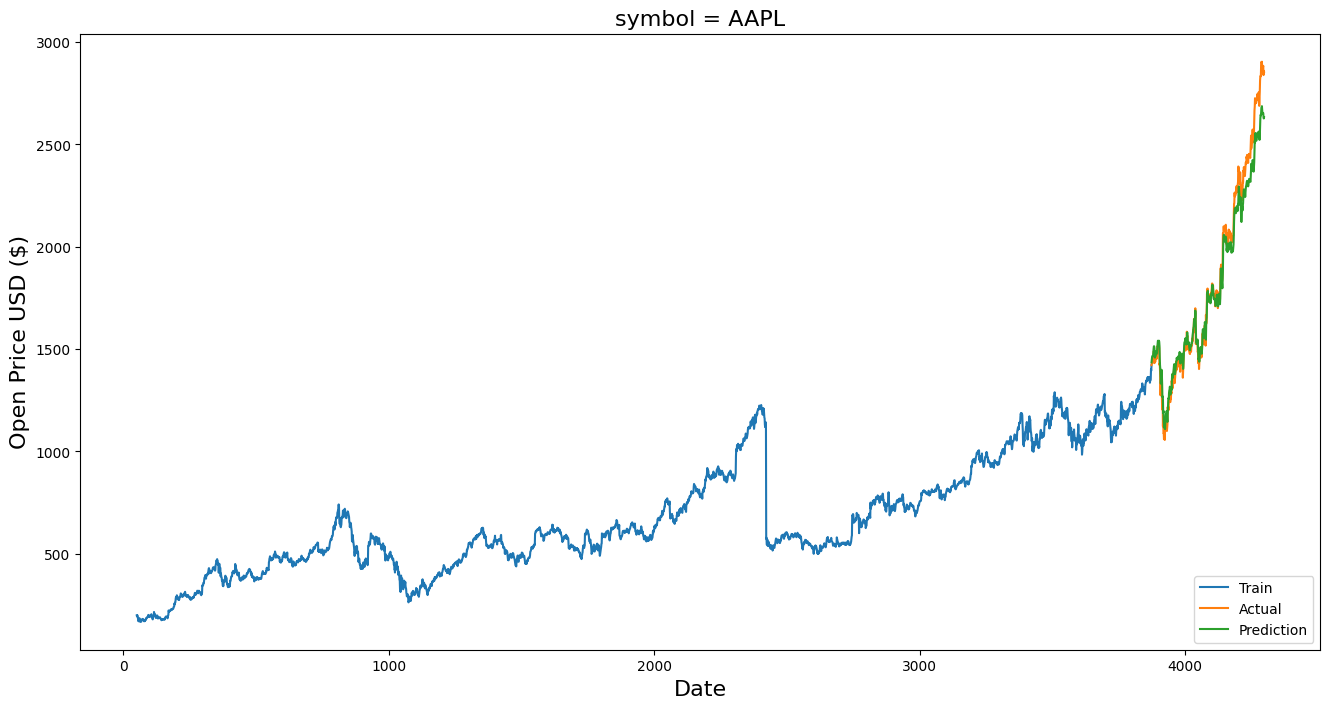

In [25]:
# Visualize the data
plt.figure(figsize=(16,8))
plt.title('symbol = '+symbol, fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Open Price USD ($)', fontsize=16)
plt.plot(train)
plt.plot(valid[['Actual','Prediction']])
plt.legend(['Train', 'Actual', 'Prediction'], loc='lower right')
plt.show()

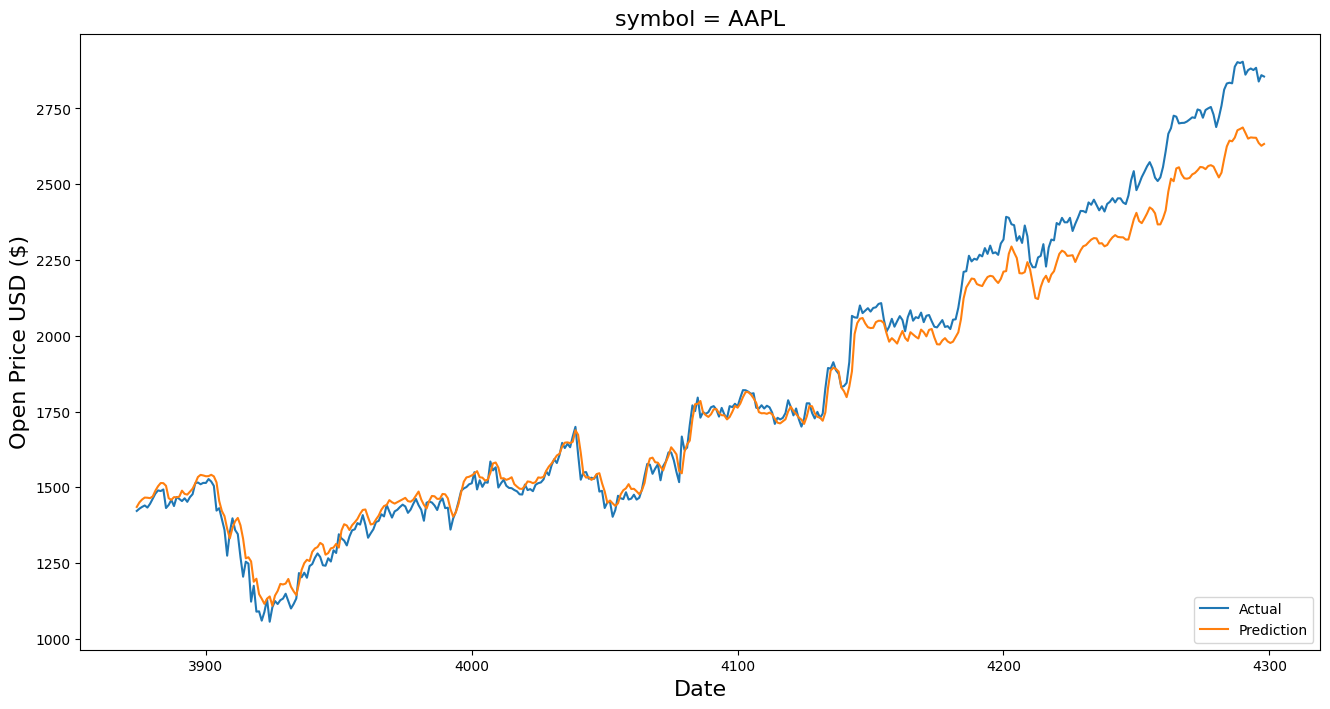

In [26]:
# Visualize the data
plt.figure(figsize=(16,8))
plt.title('symbol = '+symbol, fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Open Price USD ($)', fontsize=16)
plt.plot(valid[['Actual','Prediction']])
plt.legend(['Actual', 'Prediction'], loc='lower right')
plt.show()

In [41]:
!git clone https://github.com/AmirKameel/stock.git


fatal: destination path 'stock' already exists and is not an empty directory.


In [39]:
!git init

Reinitialized existing Git repository in /content/.git/


In [40]:
!git add .

error: 'stock/' does not have a commit checked out
fatal: adding files failed


In [33]:
!git commit -m "first commit"

Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@30c23d27b07d.(none)')


In [34]:
!git add .

error: 'stock/' does not have a commit checked out
fatal: adding files failed


In [35]:
!git branch -M main

In [36]:
!git remote add origin https://github.com/AmirKameel/stock.git

In [37]:
!git push -u origin main

error: src refspec main does not match any
error: failed to push some refs to 'https://github.com/AmirKameel/stock.git'
